[link text](https://)# **Using Black's Model to Value Futures Options**

#### **Author: Zachary Wright, CFA, FRM | Last Updated: 03/09/25**

**Overview:** In this project, I use Options, Futures, and Other Derivatives by Hull (2022) as a reference to value futures options with Black's Model (also known as Black-76) in Python and delve into sensitivity analysis and model limitations with real data. Note that while certain libraries may streamline functionality, I am attempting to develop much of the functionality myself.

Black's Model is derived from:
1.   Itô’s Lemma, which is used to describe the stochastic process of the futures price
2.   A modified Black-Scholes Partial Differential Equation, where the dividend yield equals the risk-free rate, adjusting for the fact that futures have no cost of carry

A lognormal assumption is chosen here as a baseline to capture asset price behavior. Real market behavior may deviate from such an assumption, and deviations from the assumed distribution can create mispricings and arbitrage opportunities.

**Planned Updates:**
- Option class and methods - finish methods for calculation of the Greeks
- Sensitivity and scenario analysis
- Backtesting
- Metric visualizations
- Exploration of model limitations

**Latest Changes:**
* Started class and method definitions
* Started vizualizations for sensitivity analysis
* Finished model limitations section and implemented distribution comparison and Q-Q plot

**Libraries Used:**
- Numpy
- Pandas
- SciPy
- Matplotlib
- Seaborn

---

In [44]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

Setting variables through user input:

In [ ]:
try:
  volatility = float(input("Enter volatility per annum: "))
  rfr = float(input("Enter the risk-free rate per annum: "))
  strike = float(input("Enter strike price: "))
  futures_price = float(input("Enter the futures price: "))
  time = float(input("Enter the time to contract expiration (fractions of a year): "))
  print("\nVariables set successfully.\n")
except ValueError:
  print("\n Values must be numbers and in decimal form.\n")

Enter volatility per annum: .25
Enter the risk-free rate per annum: .0433
Enter strike price: 20
Enter the futures price: 18
Enter the time to contract expiration (fractions of a year): .4

Variables set successfully.



Calculating `d1` and `d2`:

In [ ]:
d1 = ((np.log(futures_price / strike) + ((volatility**2) * (time/2))))/(volatility*np.sqrt(time))
d2 = ((np.log(futures_price / strike) - ((volatility**2) * (time/2))))/(volatility*np.sqrt(time))

print("d1: ",d1)
print("d2: ",d2)

d1:  -0.5873014683529201
d2:  -0.7454153513613391


In [ ]:
c = (np.exp(-rfr*time))*((futures_price*norm.cdf(d1)) - (strike*norm.cdf(d2)))
p = (np.exp(-rfr*time))*((strike*norm.cdf(-1*d2)) - (futures_price*norm.cdf(-1*d1)))

print("Options Price: \n", "Call: ", c, "\n", "Put: ", p , "\n")

Options Price: 
 Call:  0.44502958291812156 
 Put:  2.410687840892953 



Since this is functionality we may want to consider for multiple different futures options, I will create an Options class to get individual call and put option prices. We will be able to set volatility, strike price, futures price, risk-free rates, and time to expiration for each. I will also incorporate methods to get the Greeks of each `FuturesOption` object.

In [ ]:
class FuturesOption:
  def __init__(self,volatility,strike,futures_price,rfr,time):
    self.volatility = volatility
    self.strike = strike
    self.futures_price = futures_price
    self.rfr = rfr
    self.time = time

  def compute_d1_d2(self):
      self.d1 = (np.log(self.futures_price / self.strike) + (self.volatility**2 * self.time / 2)) / (self.volatility * np.sqrt(self.time))
      self.d2 = self.d1 - self.volatility * np.sqrt(self.time)

  def get_call_price(self):
    self.compute_d1_d2()
    return (np.exp(-self.rfr*self.time))*((self.futures_price*norm.cdf(self.d1)) - (self.strike*norm.cdf(self.d2)))

  def get_put_price(self):
    self.compute_d1_d2()
    return (np.exp(-self.rfr*self.time))*((self.strike*norm.cdf(-1*self.d2)) - (self.futures_price*norm.cdf(-1*self.d1)))

  #def get_delta(self):
  #  return None

  #def get_gamma(self):
  #  return None

  #def get_rho(self):
  #  return None

  #def get_theta(self):
  #  return None

  #def get_vega(self):
  #  return None

  def update_vol(self, volatility):
    self.volatility = volatility
    self.compute_d1_d2()
    return self

  def update_time(self,time):
    self.time = time
    self.compute_d1_d2()
    return self

  def update_strike(self,strike):
    self.strike = strike
    self.compute_d1_d2()
    return self

We create an option object called `some_option` and call its methods at will, such as the call option price below:

In [ ]:
some_option = FuturesOption(volatility,strike,futures_price,rfr,time)
some_option.get_call_price()

0.44502958291812156

I run a quick volatility sensitivity vizualization on the `some_option` object below:

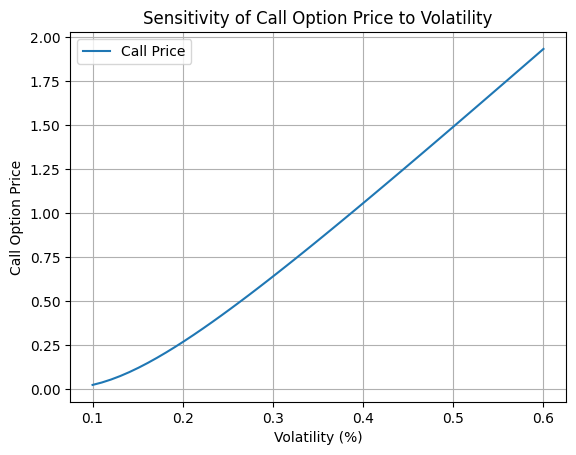

In [ ]:
vol_range = np.linspace(0.1, 0.6, 50)
call_prices = [some_option.update_vol(v).get_call_price() for v in vol_range]
plt.plot(vol_range, call_prices, label="Call Price")
plt.xlabel("Volatility (%)")
plt.ylabel("Call Option Price")
plt.title("Sensitivity of Call Option Price to Volatility")
plt.legend()
plt.grid(True)
plt.show()

I also incorporate a way to view the the call option price sensitivity for different values of the strike price.

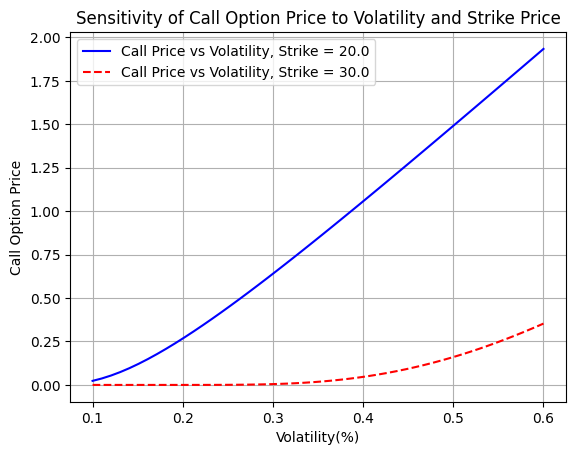

In [ ]:
initial_strike = strike
vol_range = np.linspace(0.1, 0.6, 50)
vol_call_prices1 = [some_option.update_vol(v).get_call_price() for v in vol_range]
new_strike = float(30)
some_option.update_strike(new_strike)
vol_call_prices2 = [some_option.update_vol(v).get_call_price() for v in vol_range]

plt.plot(vol_range, vol_call_prices1, label=f"Call Price vs Volatility, Strike = {initial_strike}", color="b", linestyle="-")
plt.plot(vol_range, vol_call_prices2, label=f"Call Price vs Volatility, Strike = {new_strike}", color="r", linestyle="--")
plt.xlabel("Volatility(%)")
plt.ylabel("Call Option Price")
plt.title("Sensitivity of Call Option Price to Volatility and Strike Price")
plt.legend()
plt.grid(True)
plt.show()

As expected, we see a more profound call option price sensitivity to volatility for the strike price that is closer to being at-the-money.

---
### **Limitations of Black's Model**

As mentioned previously, we make a few critical assumptions when using Black's Model that can create differences in practice, including:
- The underlying price process is lognormally distributed
- Constant volatility over life of the option
- Constant risk-free rate
- Options in question are European style
- Frictionless markets and no arbitrage

I will demonstrate the first limitation by comparing the assumed lognormal distribution to the actual distribution exhibited by the futures prices. If prices are lognormally distributed, then log returns should exhibit normality.

---
### **Analysis of Historical Data - S&P 500 e-Mini Continuous Contract**
Here I will import S&P 500 E-mini Futures price data from TradingView into a dataframe called `df` and calculate the log returns. Then I will display the actual distribution of returns in a chart. The data are daily returns on the S&P 500 e-Mini Continuous Contract since February 2, 2015.



In [14]:
df = pd.read_csv("/content/CME_MINI_DL_ES1!.csv",header=0)

In [15]:
df.head()

,time,open,high,low,close,Basis,Upper,Lower,EMA,EMA.1,Volume,RSI,Regular Bullish,Regular Bullish Label,Hidden Bullish,Hidden Bullish Label,Regular Bearish,Regular Bearish Label,Hidden Bearish,Hidden Bearish Label
0,2/2/2015,1990.50,2018.50,1973.75,2017.0,2020.550,2061.306779,1979.793221,2025.614526,2024.059174,2038824,48.145509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2/3/2015,2015.00,2044.00,2007.00,2042.0,2021.850,2063.590089,1980.109911,2026.257094,2025.767824,1705780,52.775447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2/4/2015,2040.50,2049.25,2022.75,2030.0,2023.625,2063.541319,1983.708681,2026.403874,2026.170889,1696963,50.447084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2/5/2015,2025.00,2058.75,2020.75,2055.0,2025.400,2067.521075,1983.278925,2027.525291,2028.916518,1343547,54.910223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2/6/2015,2056.25,2068.00,2044.50,2053.0,2025.300,2067.148118,1983.451882,2028.524299,2031.210183,1722475,54.487416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


With the dataframe loaded with the price data, I create a new dataframe with the transformed data called `newdf`:

In [36]:
newdf = df[['time', 'close']].copy()
newdf['close'].astype(float)
newdf['time'] = pd.to_datetime(newdf['time'])
newdf = newdf.set_index('time')
newdf['log_return'] = np.log(newdf['close'] / newdf['close'].shift(1))
newdf = newdf.dropna()

In [37]:
newdf

,close,log_return
time,,
2015-02-03,2042.00,0.012318
2015-02-04,2030.00,-0.005894
2015-02-05,2055.00,0.012240
2015-02-06,2053.00,-0.000974
2015-02-09,2042.50,-0.005128
...,...,...
2025-03-04,5789.50,-0.012232
2025-03-05,5851.25,0.010609
2025-03-06,5746.25,-0.018108


Next, I will visualize these returns in Seaborn and compare them versus a normal distribution.

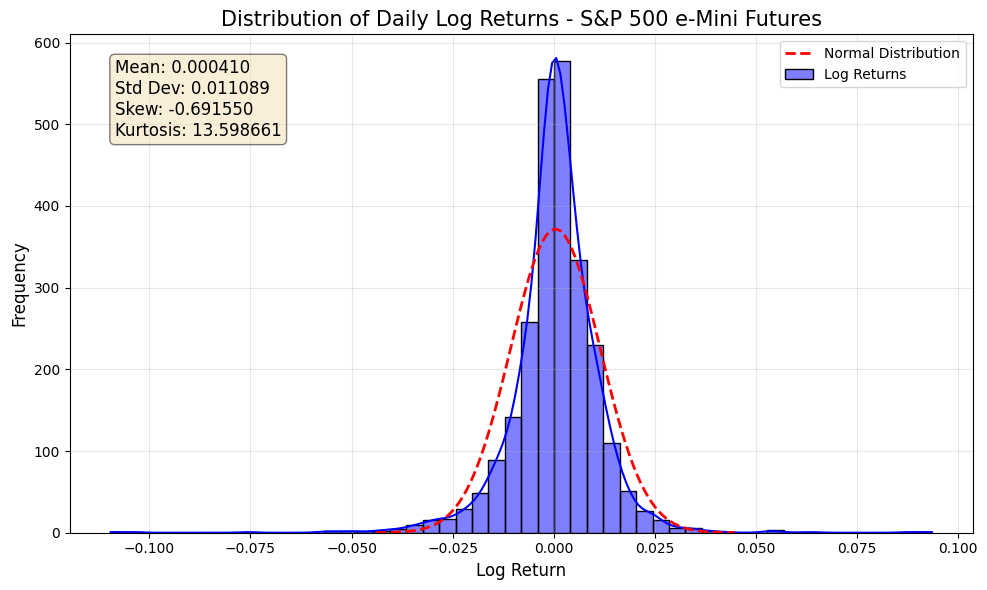

In [40]:
plt.figure(figsize=(10, 6))
sns.histplot(newdf['log_return'], kde=True, bins=50, color='blue', label='Log Returns')

mu = newdf['log_return'].mean()
sigma = newdf['log_return'].std()
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
y = 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2/(2*sigma**2))
scale_factor = len(newdf['log_return']) * (max(newdf['log_return']) - min(newdf['log_return'])) / 50  # Scale to match histogram
plt.plot(x, y*scale_factor, 'r--', linewidth=2, label='Normal Distribution')

plt.title('Distribution of Daily Log Returns - S&P 500 e-Mini Futures', fontsize=15)
plt.xlabel('Log Return', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(loc='upper right', fontsize=10)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textstr = f'Mean: {mu:.6f}\nStd Dev: {sigma:.6f}\nSkew: {newdf["log_return"].skew():.6f}\nKurtosis: {newdf["log_return"].kurtosis():.6f}'
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Here,  we clearly see fatter tails than assumed and we also see that the actual data demonstrate a higher peak.

The implication of this are as follows:
- Kurtosis value (13.59) implies that extreme market moves occur more frequently than predicted by a normal distribution
- This leptokurtic distribution suggests that options may be underpriced by Black's Model during normal market conditions but potentially overpriced during extreme events
- Risk management strategies based on normal distribution assumptions may underestimate the probability of large price movements

To hammer these points home, I present a Quantile-Quantile Plot to compare the distributions further:

<Figure size 1000x600 with 0 Axes>

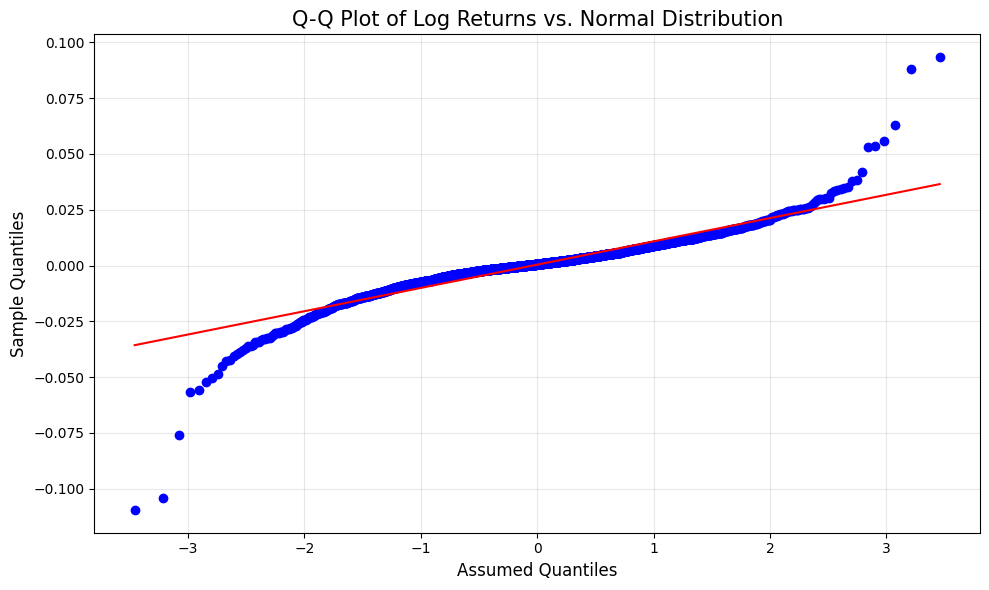

In [49]:
plt.figure(figsize=(10, 6))
log_returns = newdf['log_return'].astype(float)
fig = plt.figure(figsize=(10, 6))
res = stats.probplot(log_returns, dist="norm", plot=plt)

plt.title('Q-Q Plot of Log Returns vs. Normal Distribution', fontsize=15)
plt.xlabel('Assumed Quantiles', fontsize=12)
plt.ylabel('Sample Quantiles', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

We see that the tails of the distribution deviate significantly from normality. Among other things, the market may price in this deviation and create a "volatility smile" effect on options in the market.